**Importok és alapbeállítások**

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Path-ek beállítasa**

In [14]:
#dataset eleresi utvonala
DATASET_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
WEIGHTS_PATH = "/kaggle/input/keras-resnet50-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 6
EPOCHS_FINE = 6
SEED = 42

#output pathek letrehozasa(letoltheto a vegen)
OUT_ROOT = "/kaggle/working"
FIG_DIR = os.path.join(OUT_ROOT, "figures")
MET_DIR = os.path.join(OUT_ROOT, "metrics")
MODEL_DIR = os.path.join(OUT_ROOT, "models")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MET_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

**Adatbetöltés (augmentáció + class weight opció)**

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.06,
    height_shift_range = 0.06,
    horizontal_flip = True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    shuffle = False
)

print("Class indices:", train_gen.class_indices)

#class weight az egyensulytalansag miatt
#kiszamoljuk a train set alapjan

counts = np.bincount(train_gen.classes)
total = counts.sum()
class_weight = {0: total/(2*counts[0]), 1: total/(2*counts[1])}
print("Train class counts:", counts, "class_weight:", class_weight)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Train class counts: [1341 3875] class_weight: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


**Modell: ResNet50 + saját head**

In [16]:
base = ResNet50(
    weights = None,
    include_top = False,
    input_tensor = Input(shape=(224, 224, 3))
)

#sulyok betoltese helyi fajlbol
base.load_weights(WEIGHTS_PATH)

#1. fazis: fagyasztas
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base.input, outputs=out)

model.compile(
    optimizer = Adam(1e-4),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Callbackek (early stop, LR schedule, best checkpoint)**

In [18]:
ckpt_path = os.path.join(MODEL_DIR, "resnet50_best.keras")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-7),
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
]

**Tanítás 1.fazis (head)**

In [19]:
history1 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_INITIAL,
    callbacks = callbacks,
    class_weight = class_weight
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6


I0000 00:00:1766838397.804764    2193 service.cc:152] XLA service 0x78abc0004050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766838397.804818    2193 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766838399.706864    2193 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/163 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5703 - loss: 0.7862  

I0000 00:00:1766838403.747533    2193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 157s 889ms/step - accuracy: 0.5019 - loss: 0.7398 - val_accuracy: 0.8125 - val_loss: 0.6675 - learning_rate: 1.0000e-04
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 583ms/step - accuracy: 0.5711 - loss: 0.6758 - val_accuracy: 0.7500 - val_loss: 0.6460 - learning_rate: 1.0000e-04
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - accuracy: 0.6848 - loss: 0.6259 - val_accuracy: 0.6250 - val_loss: 0.6397 - learning_rate: 1.0000e-04
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 553ms/step - accuracy: 0.7285 - loss: 0.6053 - val_accuracy: 0.5625 - val_loss: 0.6225 - learning_rate: 1.0000e-04
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 540ms/step - accuracy: 0.7548 - loss: 0.5775 - val_accuracy: 0.6250 - val_loss: 0.6264 - learning_rate: 1.0000e-04
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 535ms/step - accuracy: 0.7795 - loss: 0.5553 - val_accuracy: 0.6250 - val_loss: 0.5902 - learning_rate: 1.0000e-04


**Fine-tuning 2.fázis (felső rétegek feloldása)**

In [20]:
#tipikusan a felso 30-50 reteget engedjuk tanulni
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer = Adam(1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history2 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_FINE,
    callbacks = callbacks,
    class_weight = class_weight
)

Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 555ms/step - accuracy: 0.7833 - loss: 0.5533 - val_accuracy: 0.5000 - val_loss: 0.6939 - learning_rate: 1.0000e-05
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 540ms/step - accuracy: 0.9315 - loss: 0.1847 - val_accuracy: 0.6250 - val_loss: 0.5441 - learning_rate: 1.0000e-05
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9304 - loss: 0.1756 - val_accuracy: 0.8125 - val_loss: 0.4305 - learning_rate: 1.0000e-05
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 528ms/step - accuracy: 0.9288 - loss: 0.1670 - val_accuracy: 0.5000 - val_loss: 1.5673 - learning_rate: 1.0000e-05
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 532ms/step - accuracy: 0.9420 - loss: 0.1420 - val_accuracy: 0.5000 - val_loss: 1.8544 - learning_rate: 1.0000e-05
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 535ms/step - accuracy: 0.9373 - loss: 0.1448 - val_accuracy: 0.6875 - val_loss: 0.9378 - learning_rate: 3.0000e-06


**Tanulási görbék mentése**

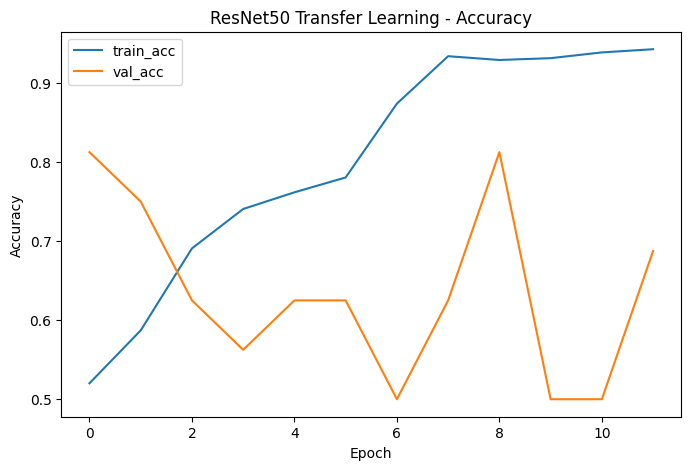

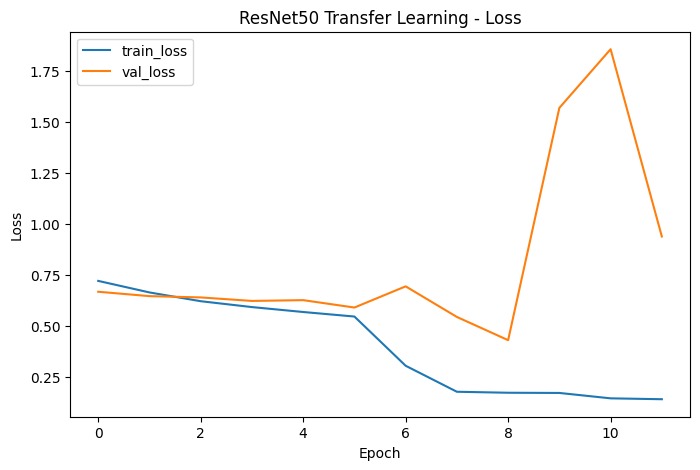

Saved: /kaggle/working/figures/resnet50_accuracy.png
Saved: /kaggle/working/figures/resnet50_loss.png


In [21]:
def merge_histories(h1, h2):
    merged = {}
    for k in h1.history.keys():
        merged[k] = h1.history[k] + h2.history[k]
    return merged

hist = merge_histories(history1, history2)

#accuracy
plt.figure(figsize=(8, 5))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Transfer Learning - Accuracy")
plt.legend()
acc_path = os.path.join(FIG_DIR, "resnet50_accuracy.png")
plt.savefig(acc_path, dpi=150, bbox_inches="tight")
plt.show()

#loss
plt.figure(figsize=(8, 5))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Transfer Learning - Loss")
plt.legend()
loss_path = os.path.join(FIG_DIR, "resnet50_loss.png")
plt.savefig(loss_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", acc_path)
print("Saved:", loss_path)

**Teszt kiertekeles + riport + confusion matrix + ROC**

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step
              precision    recall  f1-score   support

      NORMAL       0.86      0.84      0.85       234
   PNEUMONIA       0.91      0.92      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



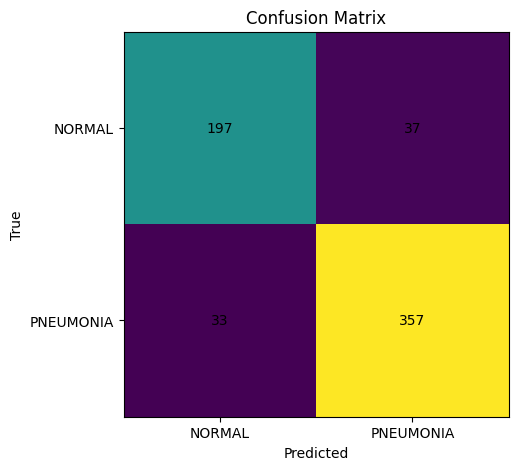

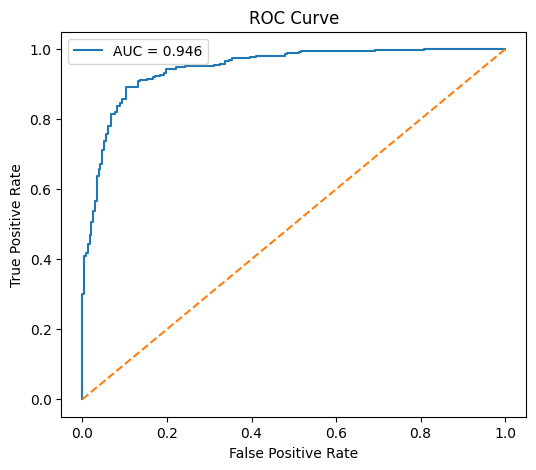

Saved: /kaggle/working/figures/resnet50_confusion_matrix.png
Saved: /kaggle/working/figures/resnet50_roc.png
Saved: /kaggle/working/metrics/resnet50_metrics.json


In [24]:
#checkpoint a legjobb
model.load_weights(ckpt_path)

test_gen.reset()
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_gen.classes

#report
report = classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"], output_dict=True)
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks([0,1], ["NORMAL", "PNEUMONIA"])
plt.yticks([0,1], ["NORMAL", "PNEUMONIA"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
cm_path = os.path.join(FIG_DIR, "resnet50_confusion_matrix.png")
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()

#ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
roc_path = os.path.join(FIG_DIR, "resnet50_roc.png")
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", cm_path)
print("Saved:", roc_path)

#metrikak mentese JSON-ba
metrics_out = {
    "model": "ResNet50_transfer",
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "epochs_total": len(hist["loss"]),
    "roc_auc": float(roc_auc),
    "confusion_matrix": cm.tolist(),
    "classification_report": report
}
met_path = os.path.join(MET_DIR, "resnet50_metrics.json")
with open(met_path, "w") as f:
    json.dump(metrics_out, f, indent=2)

print("Saved:", met_path)

**Modell mentése**

In [25]:
final_model_path = os.path.join(MODEL_DIR, "resnet50_final.keras")
model.save(final_model_path)
print("Saved:", final_model_path)

Saved: /kaggle/working/models/resnet50_final.keras
